In [11]:
from dotenv import load_dotenv
load_dotenv()

import os

import numpy as np
from pixell import enmap, enplot, reproject
import glob
import matplotlib.pyplot as plt
import emcee, corner
from astropy.io import fits
import sys
from astropy import units as u, constants as const
sys.path.insert(0, '../src')
import sys
import warnings
import os
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import yaml
import itertools
from pixell import enmap

import bandpass as bp
import covariance as cov
import model
import utils as ut

import SZpack as SZ

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def sim_check(cf):
    """
    Check if the data is simulated or real.

    Parameters
    ----------
    cf : dict
        Configuration dictionary.
    
    Returns
    -------
    data_str_flag : str
        String flag for the data type.
    """
    if cf['system_type'] == 'sim':
        data_str_flag = "_srcfree_model"
    elif cf['system_type'] == 'real':
        data_str_flag = "_srcfree"
    elif cf['system_type'] == 'real_with_sources':
        data_str_flag = ""
    else:
        raise ValueError("Undefined system type.")
    return data_str_flag

def converge_plot(sampler, object_type, labels):
    plt.figure(figsize=(12, 8))
    for idx in range(len(labels)):
        chain = sampler.get_chain()[:, :, idx].T

        N = np.exp(np.linspace(np.log(10**2), np.log(chain.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = ut.autocorr_gw2010(chain[:, :n])
            new[i] = ut.autocorr_new(chain[:, :n])

        if (object_type in labels[idx]):
            plt.loglog(N, new, "o-", label=labels[idx])
            plt.xlabel("number of samples, $N$")
            plt.ylabel(r"$\tau$ estimates")
    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    plt.legend(fontsize=8)
    plt.grid()
    plt.show()
    
def plotter_sim(filename, target, p_range, plot_contours=False,
                plot_converge=False, burnin=1, 
                plot_samples=True, truths=None,
                thin=1, plot_maps=False, cf_name="cf_auto_all.yaml"):
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    dire = f"/home/gill/research/ACT/bridge/"
    
    sampler = emcee.backends.HDFBackend(filename)
        
    cf = ut.get_config_file(cf_name)

    labels = ['c1ra', 'c1dec', 'c1beta', 'c1rc', 'c1e', 'c1theta', 'c1tau', 'c1T', 'c1Ad',
                'c2ra', 'c2dec', 'c2beta', 'c2rc', 'c2e', 'c2theta', 'c2tau', 'c2T', 'c2Ad',
                'filra', 'fildec', 'filL', 'filW', 'filtau', 'filTe', 'filAd', 'vavg']

    region = ut.get_region(cf['region_center_ra'], 
                           cf['region_center_dec'], 
                           cf['region_width'])
    
    data_ref = enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                              box=region)

    
    data_wcs = data_ref.wcs
    
    ndim = len(labels)
    
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    samples_unflat = sampler.get_chain(discard=burnin)
    
    print(f"Target: {target}")
    print("\nNumber of iterations: {:.0f}".format(samples.shape[0] / sampler.shape[0]))
    print("\nShape of sampler: {}".format(sampler.shape))
    print("Shape of samples: {}".format(samples.shape))
    print("\n******\nFit parameters (coordinates in units of pixels):\n--------")

    theta = []
        
    acc_frac = sampler.accepted / sampler.iteration
    print("*Average acceptance fraction is: {:.2f}%".format(np.mean(acc_frac)*100))

    
    for idx, label in enumerate(labels):
        mcmc_run = np.percentile(samples[:, idx], [16, 50, 84])
        q = np.diff(mcmc_run)
        
        if (label == 'c2ra' or label == 'filra' or label == 'vavg'): 
            print("\n{}: {:.4f}, -{:.4f}, {:.4f}".format(label, mcmc_run[1],  q[0], q[1]))        
        else:
            print("{}: {:.4f}, -{:.4f}, {:.4f}".format(label, mcmc_run[1],  q[0], q[1]))
        
        theta.append(mcmc_run[1])
    
    if plot_samples:
        fig, axes = plt.subplots(len(labels), figsize=(10, 35), sharex=True)

        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples_unflat[:, :, i], "k", alpha=0.4)
            ax.set_xlim(0, len(samples_unflat))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
        plt.show()

    if plot_maps:

        
        c1 = model.Cluster(theta=theta, name="abell401")
        c2 = model.Cluster(theta=theta, name="abell399")
        fil = model.Filament(theta=theta)
        
        # 98
        freq = 98

        ref_data_98 = ut.imap_dim_check(enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f098_4way_coadd_map_srcfree.fits", 
                                     box=region))

        data_shape = ref_data_98.shape
                
        xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), 
                                   np.arange(0, data_shape[0], 1))
              
        array = 'pa5'
        inst = 'act'
        scan = 'night'

        flux_factor_98 = ut.flux_factor(array, freq)

        ref_data_98 *= flux_factor_98 
        
        c1_model = c1.szmodel(frequency=freq, 
                              array=array, 
                              z=cf['c1_z'],
                              xgrid=xgrid, 
                              ygrid=ygrid,
                              ellipticity_type=cf['ellipticity_type'],
                              muo=cf['c1_muo'])
        
        c2_model = c2.szmodel(frequency=freq,
                                array=array,
                                z=cf['c2_z'],
                                xgrid=xgrid,
                                ygrid=ygrid,
                                ellipticity_type=cf['ellipticity_type'],
                                muo=cf['c2_muo'])

        fil_model = fil.szmodel(frequency=freq,
                                array=array,
                                xgrid=xgrid,
                                z=cf['fil_z'],
                                ygrid=ygrid, 
                                muo=cf['fil_muo'])
        
        total_model = c1_model + c2_model + fil_model        

        beam_98 = ut.get_2d_beam(data_shape=ref_data_98.shape, 
                                 freq=freq, 
                                 array=array, 
                                 inst='act', 
                                 version=str(cf['beam_version']),
                                 data_wcs=data_wcs)

        model_tot_98 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_98))

        # 150 GHz
        freq = 150

        ref_data_150 = ut.imap_dim_check(enmap.read_map(f"{os.environ['ACT_DATADIR']}/act_cut_dr6v2_pa5_f150_4way_coadd_map_srcfree.fits", 
                                     box=region))

        data_shape = ref_data_150.shape
        xgrid, ygrid = np.meshgrid(np.arange(0, data_shape[1], 1), 
                                   np.arange(0, data_shape[0], 1))

        array = 'pa5'
        inst = 'act'
        scan = 'night'

        flux_factor_150 = ut.flux_factor(array, freq)

        ref_data_150 *= flux_factor_150   
        
        c1_model = c1.szmodel(frequency=freq, 
                              array=array, 
                              z=cf['c1_z'],
                              xgrid=xgrid,
                              ygrid=ygrid,
                              ellipticity_type=cf['ellipticity_type'],
                              muo=cf['c1_muo'])
        
        c2_model = c2.szmodel(frequency=freq,
                                array=array,
                                z=cf['c2_z'],
                                xgrid=xgrid,
                                ygrid=ygrid,
                                ellipticity_type=cf['ellipticity_type'],
                                muo=cf['c2_muo'])

        fil_model = fil.szmodel(frequency=freq,
                                array=array,
                                xgrid=xgrid,
                                z=cf['fil_z'],
                                ygrid=ygrid, muo=cf['fil_muo'])
        

        total_model = c1_model + c2_model + fil_model

        beam_150 = ut.get_2d_beam(data_shape=ref_data_150.shape, 
                                 freq=freq, 
                                 array=array, 
                                 inst='act', 
                                 version=str(cf['beam_version']),
                                 data_wcs=data_wcs)
        
        model_tot_150 = np.real(np.fft.ifft2(np.fft.fft2(total_model) * beam_150))

        lab = f"I [mJy / steradian]"
        
        fig = plt.figure(figsize=(18, 85)) # create the canvas for plotting
        
        nrows = 12
        ncols = 3
        
        inst_dict = {'30':'Planck', '44':'Planck', '70':'Planck',
                     '100':'Planck', '143':'Planck', '217':'Planck',
                     '353':'Planck', "545":'Planck', "857":'Planck',
                     "98":'ACT', "150":'ACT', "220":'ACT'}
        
        array_dict = {'30':'npipe', '44':'npipe', '70':'npipe',
                      '100':'npipe', '143':'npipe', '217':'npipe',
                      '353':'npipe', "545":'npipe', "857":'npipe',
                      "98":'pa5', "150":'pa5', "220":'pa4'}
        
#         ref_data_dict = {'30':ref_data_30, '44':ref_data_44, '70':ref_data_70,
#                          '98':ref_data_98, '100':ref_data_100, '143':ref_data_143, 
#                          '150':ref_data_150, '217':ref_data_217, '220':ref_data_220,
#                          '353':ref_data_353, '545':ref_data_545, '857':ref_data_857}
        
#         model_tot_dict = {'30':model_tot_30, '44':model_tot_44, '70':model_tot_70,
#                          '98':model_tot_98, '100':model_tot_100, '143':model_tot_143, 
#                          '150':model_tot_150, '217':model_tot_217, '220':model_tot_220,
#                          '353':model_tot_353, '545':model_tot_545, '857':model_tot_857}
        
        ref_data_dict = {'98':ref_data_98, '150':ref_data_150}
        model_tot_dict = {'98':model_tot_98, '150':model_tot_150}

        freqs = ['30', '44', '70', '98', '100', '143', '150', '217', '220', '353', '545', '857']
        
        inst_dict = {'98':"ACT", "150":"ACT", "220":"ACT"}
        freqs = ['98', '150']
        
        for i, freq in enumerate(freqs):
                        
            ref_data = ref_data_dict[freq]
            model_tot = model_tot_dict[freq]
            
            ax1 = fig.add_subplot(nrows, ncols, i*3+1)
            im1 = ax1.imshow(ref_data / 10**3, origin='lower')
            ax1.invert_xaxis()
            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Data, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
        
            ax1 = fig.add_subplot(nrows, ncols, i*3+2)
            im1 = ax1.imshow(model_tot / 10**3, origin='lower')
            ax1.invert_xaxis()

            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            #ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Model, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
            
            ax1 = fig.add_subplot(nrows, ncols, i*3+3)
            im1 = ax1.imshow((ref_data - model_tot) / 10**3, origin='lower')
            ax1.invert_xaxis()
            cb1 = fig.colorbar(im1, cmap='viridis', ax=ax1, orientation="horizontal", pad=0.12)
            cb1.set_label(lab)
            #ax1.set_ylabel('Declination [pixels]')
            ax1.set_xlabel('Right ascension [pixels]')
            ax1.set_title(f"Residual, {inst_dict[freq]}, {array_dict[freq]}, {freq} GHz", fontsize=16)
        
        #plt.savefig(f"figs/{target}.png", bbox_inches='tight')
        plt.show()
    
    if plot_converge:
        converge_plot(sampler, "c1", labels)
        converge_plot(sampler, "c2", labels)
        converge_plot(sampler, "fil", labels)
        converge_plot(sampler, "vavg", labels)

    if plot_contours: 
        
        if truths is not None:
            figure = corner.corner(samples, 
                                   labels=labels,
                                   truths=truths,
                                   range=p_range,                                  
                                   quantiles=[0.16, 0.5, 0.84],
                                   show_titles=True, 
                                   plot_datapoints=True,
                                   title_fmt=".3f")
        else:
            figure = corner.corner(samples, 
                       labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, 
                       range=p_range,
                       plot_datapoints=True,
                       title_fmt=".3f")
        plt.show()
        
    return None

Target: bridge

Number of iterations: 180

Shape of sampler: (100, 26)
Shape of samples: (18000, 26)

******
Fit parameters (coordinates in units of pixels):
--------
*Average acceptance fraction is: 26.17%
c1ra: 153.7559, -0.5037, 0.4589
c1dec: 168.3157, -0.2833, 0.3060
c1beta: 1.0791, -0.1597, 0.1726
c1rc: 3.7932, -1.4141, 1.0878
c1e: 2.7226, -0.7159, 0.9023
c1theta: 93.5154, -28.1740, 20.9943
c1tau: 0.0082, -0.0026, 0.0031
c1T: 8.5763, -0.5144, 0.4278
c1Ad: 1384484.1039, -741416.6817, 949835.9517

c2ra: 117.9314, -1.0190, 0.9119
c2dec: 106.5684, -1.5410, 1.6234
c2beta: 1.3157, -0.2071, 0.2210
c2rc: 4.0397, -1.0153, 1.1707
c2e: 3.8165, -1.1160, 1.1973
c2theta: 66.9532, -14.7584, 25.4626
c2tau: 0.0107, -0.0030, 0.0027
c2T: 7.3652, -0.3398, 0.3265
c2Ad: 524742.5152, -156077.6326, 161118.7340

filra: 141.2770, -4.4662, 5.3658
fildec: 143.9411, -5.6466, 6.9007
filL: 49.8957, -15.2616, 10.3306
filW: 30.0610, -10.5585, 16.2609
filtau: 0.0016, -0.0007, 0.0007
filTe: 6.5649, -0.6317, 0.5435


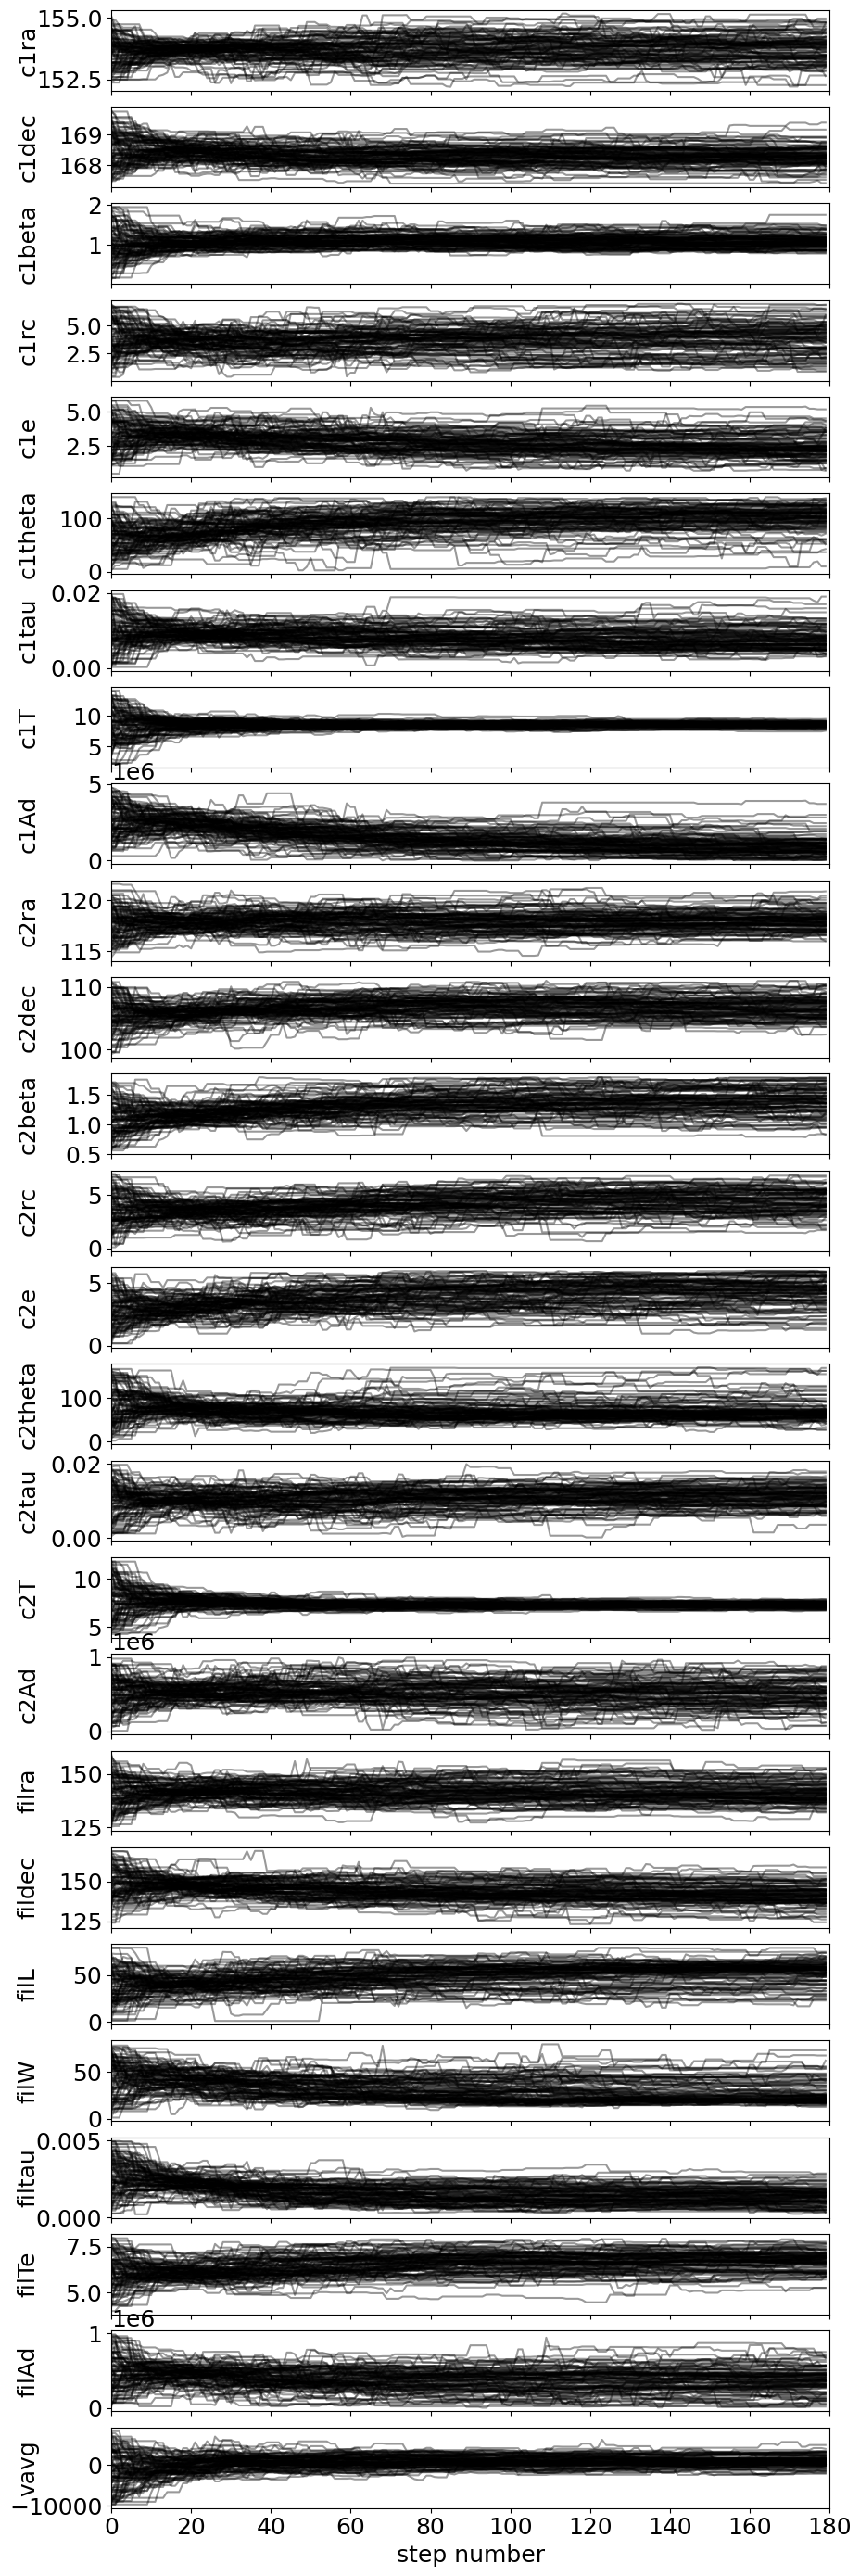

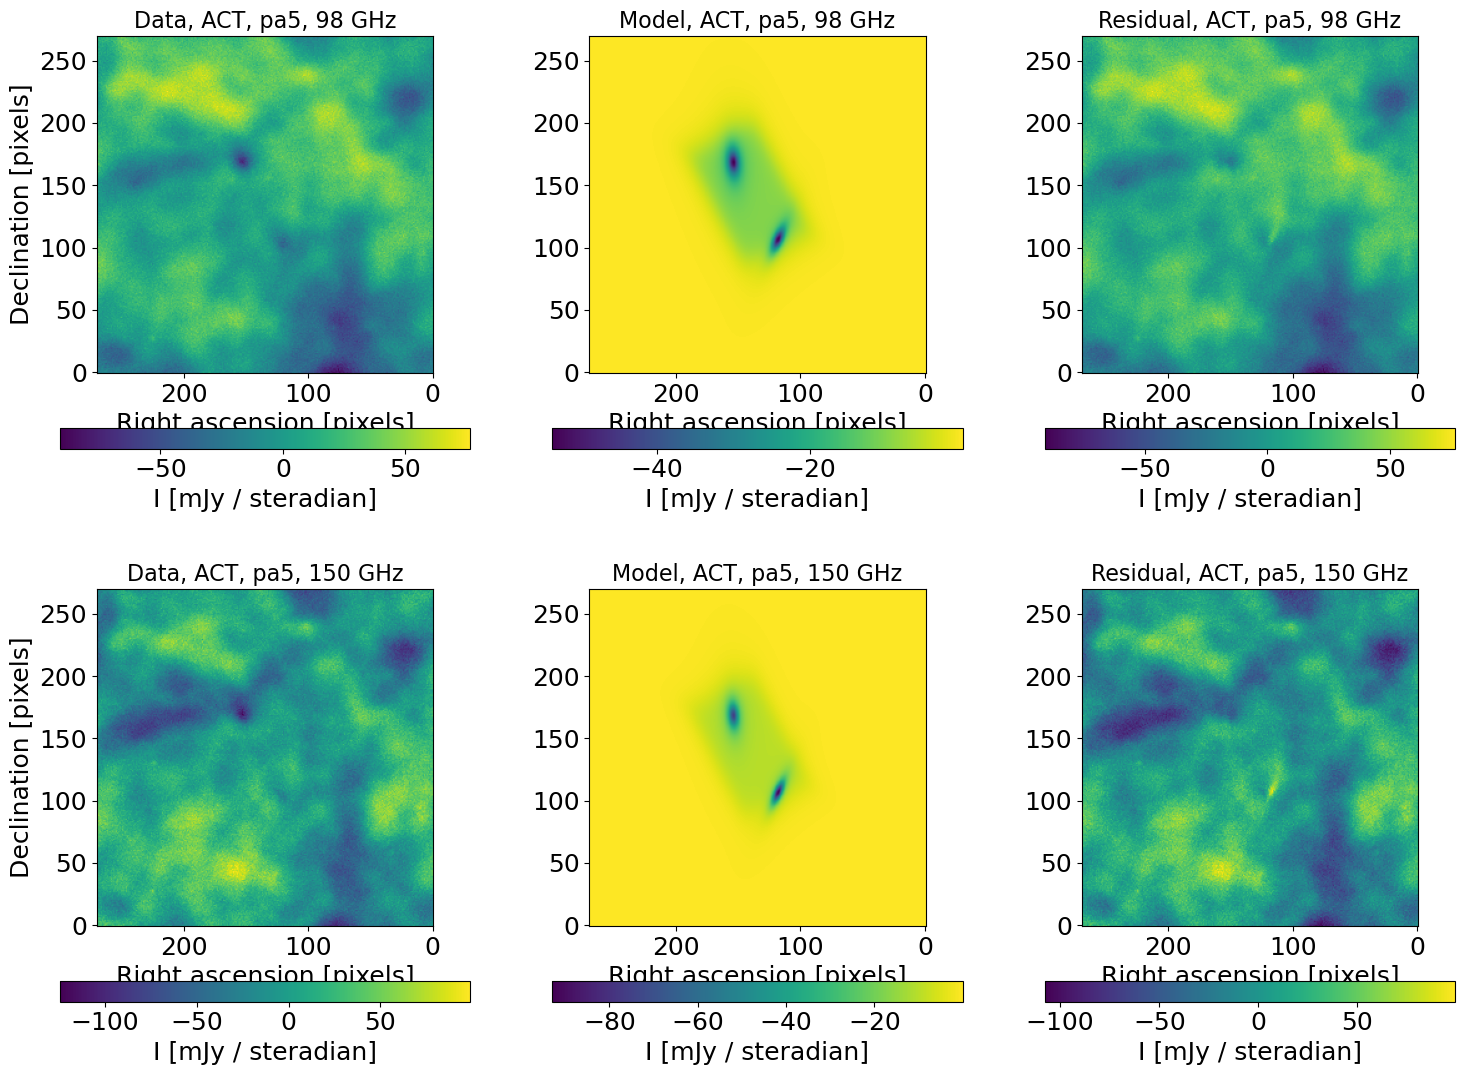

In [ ]:
target = "bridge"
case_number = 34

model_tot = plotter_sim(filename=f"/home/gill/research/ACT/bridge/a399_a401/cases/case{case_number}/chain.h5", 
                        target=f"{target}",
                        plot_maps=1,
                        burnin=1,
                        thin=1,
                        plot_contours=1,
                        p_range=None,
                        plot_samples=1,
                        cf_name=f"/home/gill/research/ACT/bridge/a399_a401/cases/case{case_number}/config.yaml",
                        plot_converge=0)